## Core

- Measure fluxes from a region at multiple frequencies



In [1]:
import numpy as np
from astropy.io import ascii, fits
import fluxInt
import pbCorr
import synCl
import convRegr
from prettytable import PrettyTable
import shutil,os, string
import fitSource

from matplotlib import pyplot as plt
from matplotlib import rc
from matplotlib import gridspec
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, LogLocator
import matplotlib.ticker
from matplotlib import transforms as mtransforms
from matplotlib.ticker import LogLocator, FormatStrFormatter
from matplotlib.ticker import StrMethodFormatter

C = 2.99792458e8


ftSrc = fitSource.fitSrc()
fint = fluxInt.flInt()

#rootdir
#rootDir = '/Users/maccagni/Projects/MFS/FornaxA/contData/kore/'
rootDir = '/home/maccagni/Projects/MFS/FornaxA/contData/core/'

#label

aut='F8'

subRegions = ['cjet/','centre/','jet/']
labelReg = ['cjFine','cFine','jFine']
jCount = [8,5,7]

imDir = rootDir+'inIms/'
fint.rootdir = imDir

regDir = imDir+'inReg/'
outTabs = rootDir+'outTabs/'
figDir = rootDir+'coreFigs/'

#input image
inIm = imDir+'Meer_1440MHz_pbcorr_cutCtr.fits'
noise = 0.
errFlux = 15.

#output table 
labelDim = ['1D','2D']
outTables = [outTabs+'jCjFluxWidth'+labelDim[0]+'.tbl',outTabs+'jCjFluxWidth'+labelDim[1]+'.tbl']

beta = 0.2
alpha =0.6
#-------------------------------------------------#
# Jet and counter-jet flux ratio
#-------------------------------------------------#
def splitter(A):
    B = A[0:len(A)//2]
    C = A[len(A)//2:]

    return (B,C)


print '''\t+---------+\n\t Inputs loaded\n\t+---------+'''


	+---------+
	 Inputs loaded
	+---------+


/home/maccagni/programs/radiobs/fluxInt.py:137: RuntimeWarning: invalid value encountered in less
  index_cut = datas < self.cutoff


0.00188840753245
8.631248155747374e-06
[2.61630814e-04 1.35380037e+01 1.65040241e+01]


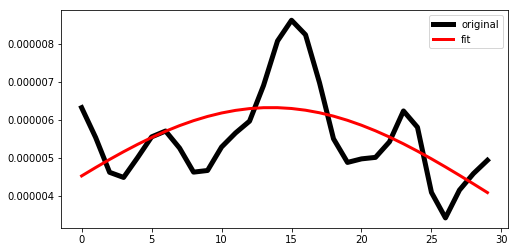

0.00188840753245
2.0535245999416667e-05
[3.38932396e-04 1.40326084e+01 8.77608826e+00]


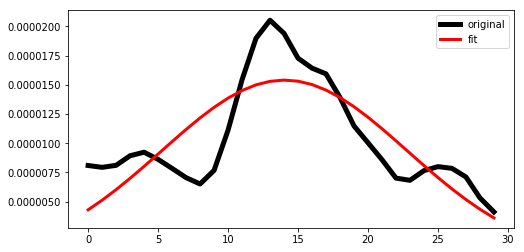

0.00188840753245
3.0687625780955855e-05
[3.15219619e-04 1.40162950e+01 4.63025900e+00]


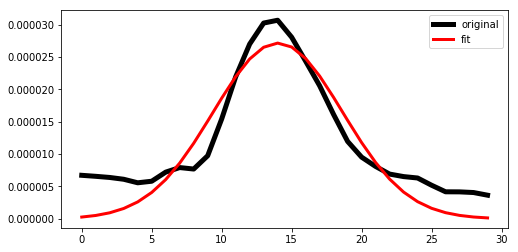

0.00188840753245
6.300145174382632e-05
[5.14692260e-04 1.42176013e+01 3.56853663e+00]


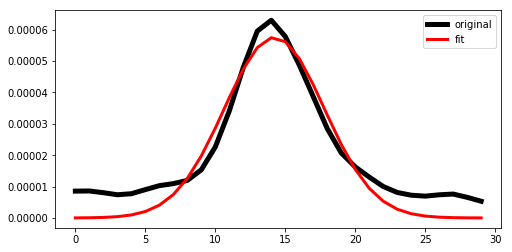

0.00188840753245
5.976461342995657e-05
[4.41061298e-04 1.45440398e+01 3.04529500e+00]


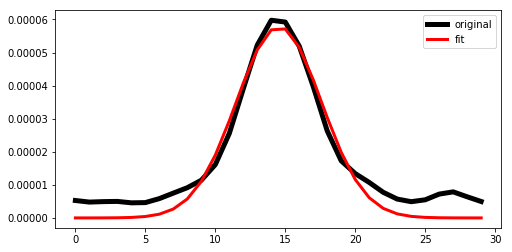

0.00188840753245
9.610362348942175e-05
[6.48854277e-04 1.47829343e+01 2.85083824e+00]


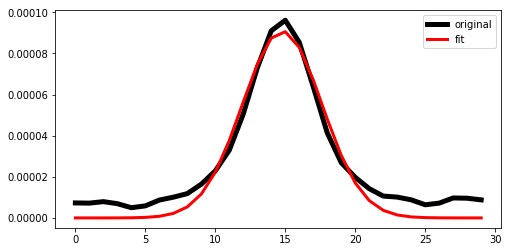

0.00188840753245
8.523169129777906e-05
[5.39813618e-04 1.48613944e+01 2.67368523e+00]


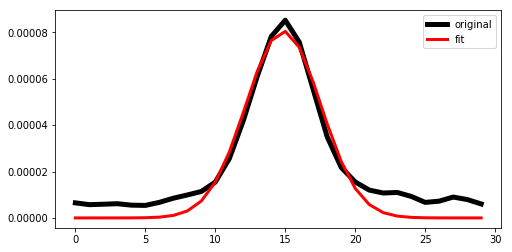

0.00188840753245
0.00012672453762219962
[8.54338800e-04 1.55217570e+01 2.92259626e+00]


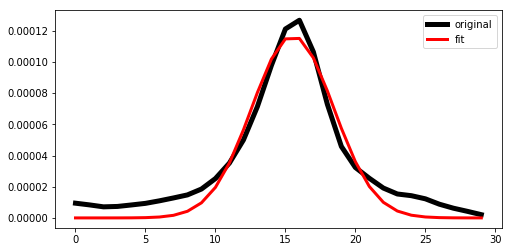

0.00188840753245
0.00022793864461245043
[9.26420471e-04 1.28266869e+01 1.72658287e+00]


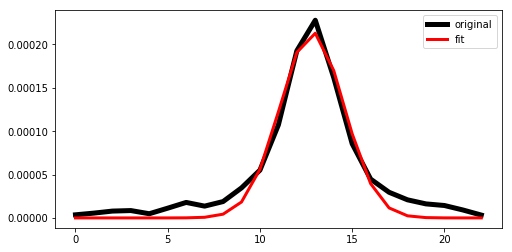

0.00188840753245
0.0009369299461066827
[ 3.07975381e-03  1.24737768e+01 -1.22746374e+00]


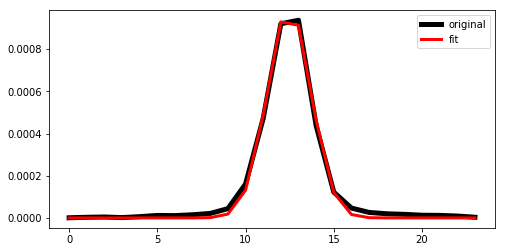

0.00188840753245
0.0036519844400764428
[ 1.11238215e-02  1.13850676e+01 -1.14420026e+00]


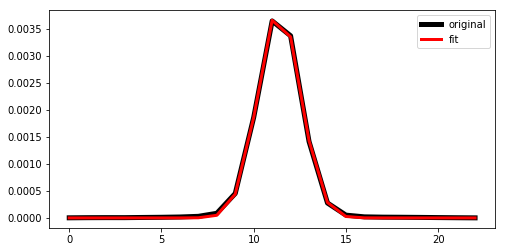

0.00188840753245
0.0017724443605066237
[ 5.85947946e-03  1.13758317e+01 -1.31384658e+00]


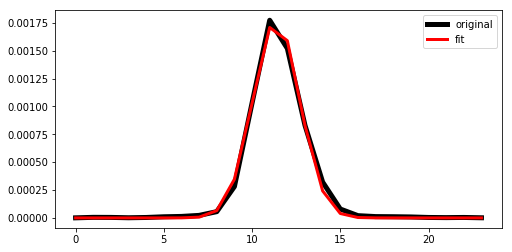

0.00188840753245
0.0010580164250379143
[ 4.05841499e-03  1.12537969e+01 -1.50670642e+00]


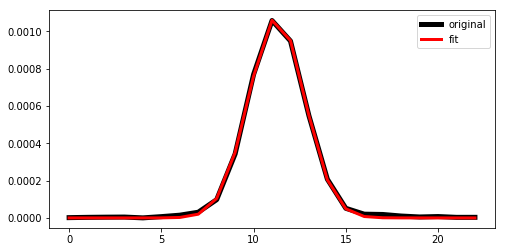

0.00188840753245
0.0008189068323482514
[5.12194579e-03 1.21012655e+01 2.45777999e+00]


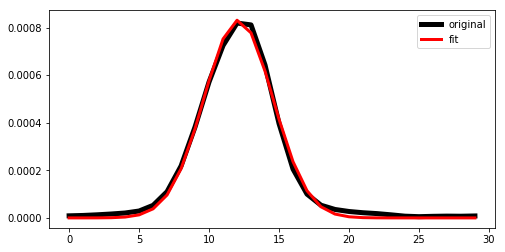

0.00188840753245
0.00023851123175715853
[1.47258377e-03 1.43505971e+01 2.63691543e+00]


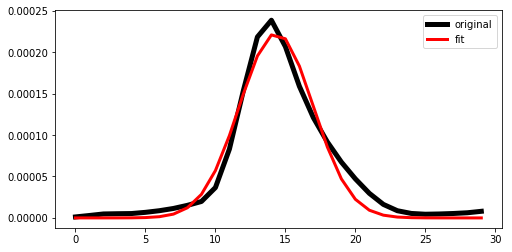

0.00188840753245
0.00020640968098012573
[1.40755478e-03 1.54687120e+01 2.67520494e+00]


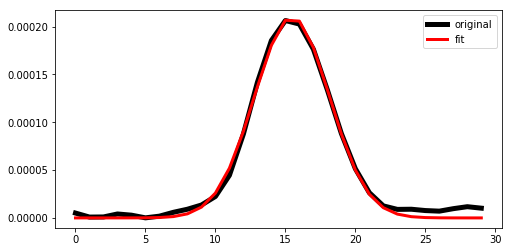

0.00188840753245
0.00011459815348294614
[7.83999699e-04 1.50381340e+01 2.69509459e+00]


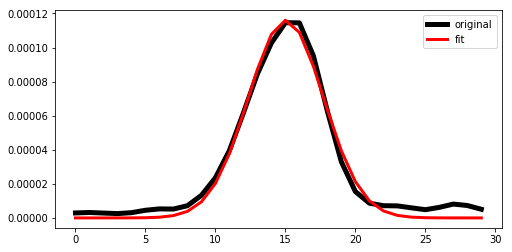

0.00188840753245
7.545962479397166e-05
[6.36127758e-04 1.46967302e+01 3.37690376e+00]


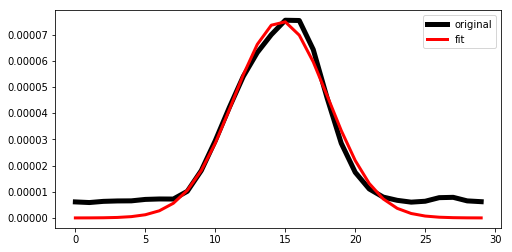

0.00188840753245
2.709061750390029e-05
[2.79746573e-04 1.44775474e+01 4.62441001e+00]


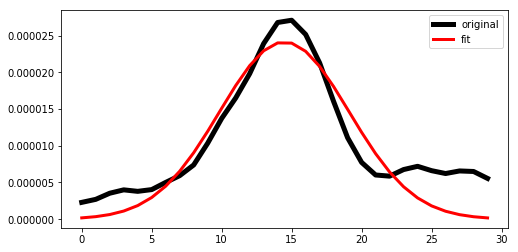

0.00188840753245
1.4345601230421976e-05
[2.72600167e-04 1.50313769e+01 1.02769614e+01]


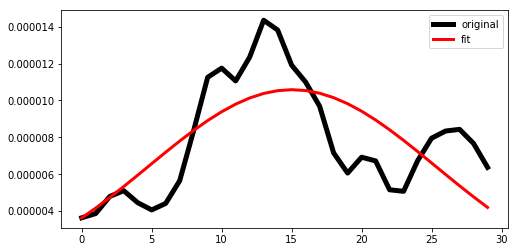

	+---------+
	 Flux & size variation along jet
	+---------+


In [2]:
#-------------------------------------------------#
# Jet and counter-jet analysis
#-------------------------------------------------#
def gauss1D( x, amp, xc, sigma):
    
        return amp*np.exp( -(x-xc)**2 / (2*sigma**2)) / np.sqrt(2*np.pi*sigma**2)

datas,heads = fint.openFile(inIm)
#Regions where to measure flux
for i in xrange(0,len(labelDim)):
    if os.path.exists(outTables[i]):
        os.remove(outTables[i])

fr=[]
flIntBeamArray=[]
flErrBeamArray=[]
flIntOutArray=[]
flErrOutArray=[]

for i in xrange(0,len(subRegions)):
#for i in xrange(0,1):

#    for j in xrange(0,1):

    for j in xrange(0,jCount[i]):
        dd = datas.copy()
        
        region = regDir+subRegions[i]+labelReg[i]+str(j)+'.reg'

        maskedData, background, rms, pixels=fint.maskDatReg(dd,heads,region,noise)
        
        fits.writeto(rootDir+str(i)+'_mask_jCj.fits',maskedData,heads,overwrite=True)

        maskedData[maskedData==0.0] = np.nan

        fluxint, numPixBeam =fint.measFlux(maskedData,heads,errFlux,'none')
        
        maskedData[np.isnan(maskedData)] = 0.0
        
        params2D = ftSrc.fit2Dgaussian(maskedData)

        #params2D = ftSrc.fitgauss2D(maskedData)
        #print params2D
        
        compressedData = np.nanmean(maskedData,axis=1)
        compressedData[np.isnan(compressedData)] = 0.0        
        
        peakIm = np.nanmax(compressedData)
        print peakIm
        compressedData= compressedData[compressedData != 0]
        params1D = ftSrc.gaus1Dfit(compressedData)
        params1D = ftSrc.fitgauss1D(compressedData)
        print params1D
     

        plt.figure(figsize=(8,4))
        x=np.arange(compressedData.shape[0])
        plt.plot(x, compressedData, linewidth=5, color='k', label='original')
        plt.plot(x, gauss1D(x, *params1D), linewidth=3, color='r', label='fit')#
        plt.legend()
        plt.show()
        
        regionName =  string.split(region,'/')[-1]
        
        params2D = np.insert(params2D,0,peakIm)
        params2D = np.insert(params2D,0,fluxint)

        params1D = np.insert(params1D,0,peakIm)
        params1D = np.insert(params1D,0,fluxint)
        
        params1D[2]= params1D[2]/np.sqrt(2*np.pi*params1D[4]**2)

        params2D[2]= params2D[2]/np.sqrt(2*np.pi*params2D[4]**2)

        for k in xrange(0,len(labelDim)):
            if k==0:
                t = ftSrc.writeGaus1DfitTable(regionName,outTables[k],params1D)
            elif k==1:
                t = ftSrc.writeGaus2DfitTable(regionName,outTables[k],params2D)
                
widthBeam = heads['BMAJ']*3600.     
for i in xrange(0,len(labelDim)):
    
    table= ascii.read(outTables[i])
    #define parameters
    width = table['width X']*2.355*heads['CDELT2']*3600. #from sigma in pix to fwhm in arcsec. 
    widthReal = width.copy()
    for j in xrange(0,len(width)):
        if width[j]>=widthBeam:
            widthReal[j] = np.sqrt(np.power(width[j],2)-np.power(widthBeam,2))
        else:
            widthReal[j] = widthBeam
    
    surfBright = table['PeakGaus']*np.sqrt((np.power(widthReal,2)/np.power(widthBeam,2)+1))
    
    table.add_column(surfBright, name='surfaceBrightness')
    table.add_column(widthReal, name='deconvolvedWidth')
    
    ascii.write(table,outTables[i], overwrite=True)

    #for k in xrange(0,len(labelDim)):
    #    if k==0:
    #       t = ftSrc.writeGaus1DfitTable(regionName,outTables[k],params1D)
    #    elif k==1:
    #        t = ftSrc.writeGaus2DfitTable(regionName,outTables[k],params2D)
        
        
print '''\t+---------+\n\t Flux & size variation along jet\n\t+---------+'''
  

In [50]:
def ticks_format(value, index):
    """
    get the value and returns the value as:
       integer: [0,99]
       1 digit float: [0.1, 0.99]
       n*10^m: otherwise
    To have all the number of the same size they are all returned as latex strings
    """
    exp = np.floor(np.log10(value))
    base = value/10**exp
    if exp == 0 or exp == 1:   
        return '${0:d}$'.format(int(value))
    if exp == -1:
        return '${0:.1f}$'.format(value)
    if exp == -2:
        return '${0:.2f}$'.format(value)
    if exp == -3:
        return '${0:.3f}$'.format(value)
    if exp == -4:
        return '${0:.4f}$'.format(value)
    else:
        return '${0:d}\\times10^{{{1:d}}}$'.format(int(base), int(exp))

def jCjPlot(radius,brightJet, brightCJet,sizeJet,sizeCJet,ratio,width,m,b,outfile):

    params = {'font.family'         :' serif',
              'font.style'          : 'normal',
              'font.weight'         : 'book',
              'font.size'           : 30.0,
              'axes.linewidth'      : 3,
              'lines.linewidth'     : 3,
              'xtick.labelsize'     : 26,
              'ytick.labelsize'     : 26, 
              'xtick.direction'     :'in',
              'ytick.direction'     :'in',
              'xtick.top'           : True,   # draw ticks on the top side
              'xtick.bottom'        : True,   # draw ticks on the bottom side    
              'ytick.left'          : True,   # draw ticks on the top side
              'ytick.right'         : True,   # draw ticks on the bottom side  
              'xtick.major.size'    : 8,
              'xtick.major.width'   : 3,
              'xtick.minor.size'    : 4,
              'xtick.minor.width'   : 2,
              'ytick.major.size'    : 8,
              'ytick.major.width'   : 3,
              'ytick.minor.size'    : 4,
              'ytick.minor.width'   : 2, 
              'text.usetex'         : True,
              'text.latex.unicode'  : True
               }
    plt.rcParams.update(params)

    # initialize figure
    fig = plt.figure(figsize=(20,20),constrained_layout=True,)

    #fig.subplots_adjust(hspace=0.0)
    gs = gridspec.GridSpec(2, 2)
    plt.rc('xtick')


    # Initialize subplots
    ax1 = fig.add_subplot(gs[0,0])
    ax1.set_xlabel(r'distance from core [arcsec]')
    ax1.set_ylabel(r'$I$ [Jy beam$^{-1}$]')
    ax1.set_xscale("log", nonposx='clip')
    ax1.set_yscale("log", nonposy='clip')
    

    #ax1.tick_params(axis='both', which='major', pad=5)

    #ax1.yaxis.set_major_locator(LogLocator(base=10,subs=[1e-4,1e-3,1e-2]))
    #ax1.xaxis.set_major_locator(LogLocator(base=10,subs=[1e-1]))    
    
    ax1.xaxis.set_minor_locator(LogLocator(base=10,subs=[1.0,2.0,3.0,4.0,5.0]))
    ax1.yaxis.set_minor_locator(LogLocator(base=10,subs=[1.0,3.0,6.0]))
    
    ax1.xaxis.set_major_formatter(matplotlib.ticker.NullFormatter())   # remove the major ticks
    ax1.xaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(ticks_format)) 

    ax1.yaxis.set_major_formatter(matplotlib.ticker.NullFormatter())   # remove the major ticks
    ax1.yaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(ticks_format))     
    ax1.set_ylim(0.00007,0.007)
    
    #sf = matplotlib.ticker.ScalarFormatter()

    #ax1.get_xaxis().set_major_formatter(sf)
    #ax1.get_yaxis().set_major_formatter(sf)
    
    ax1.plot(radius[:-2],brightJet[:-2],lw=3, marker='o', color='blue', linestyle=' ',label='jet',alpha=1,
             markersize=8)
    ax1.plot(radius[:-2],brightCJet[:-2],lw=3, marker='o', color='red', linestyle=' ',label='counter-jet',alpha=1,
             markersize=8)
    
    labels=ax1.get_xticks().tolist()
    #labels = [item.get_text() for item in ax1.get_xticklabels()]
    #print labels
    #labels[0] = '10'
    #labels[1] = '20'
    #labels[2] = '30'
    #labels[3] = '40'

    #ax1.set_xticklabels(labels)
    #ax1.set_xticklabels(['10', '20', '30','40', '50', '60'])

    ax1.legend = plt.legend(loc=1, prop={'size': 20})
    ax1.legend.get_frame().set_edgecolor('black')


    ax2 = fig.add_subplot(gs[0,1])
    
    ax2.set_xlabel(r'distance from core [arcsec]')
    ax2.set_ylabel(r'$w$ [arcsec]')
    ax2.set_yscale("log", nonposy='clip')
    ax2.set_xscale("log", nonposx='clip')
    
    ax2.xaxis.set_minor_locator(LogLocator(base=10,subs=[1.0,2.0,3.0,4.0,5.0]))
    ax2.yaxis.set_minor_locator(LogLocator(base=10,subs=[0.5,1.0,2.0,3.0,4.0]))
    
    ax2.xaxis.set_major_formatter(matplotlib.ticker.NullFormatter())   # remove the major ticks
    ax2.xaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(ticks_format)) 

    ax2.yaxis.set_major_formatter(matplotlib.ticker.NullFormatter())   # remove the major ticks
    ax2.yaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(ticks_format))     
    
    #ax2.set_ylim(0,40)
   # ax2.set_xlim(0,80)

    ax2.tick_params(axis='both', which='major', pad=5)

    ax2.plot(radius[:-2],sizeJet[:-2],lw=3, marker='o', color='blue', linestyle=' ',label='jet',alpha=1,
             markersize=8)
    
    ax2.plot(radius[:-2],sizeCJet[:-2],lw=3, marker='o', color='red', linestyle=' ',label='counter-jet',alpha=1,
             markersize=8)

    ax2.legend = plt.legend(loc=2, prop={'size': 20})
    ax2.legend.get_frame().set_edgecolor('black')
    
    ax3 = fig.add_subplot(gs[1,0])
    ax3.set_xlabel(r'distance from core [arcsec]')
    ax3.set_ylabel(r'$I_{\rm j}/I_{\rm cj}$')
    ax3.set_xscale("log", nonposx='clip')
    
    ax3.set_yscale("log", nonposy='clip')
    ax3.tick_params(axis='both', which='major', pad=5)

    ax3.xaxis.set_minor_locator(LogLocator(base=10,subs=[1.0,2.0,3.0,4.0,5.0]))
    ax3.yaxis.set_minor_locator(LogLocator(base=10,subs=[1.0,2.0,3.0,4.0, 5.0,6.0,7.0,8.0]))
    
    ax3.xaxis.set_major_formatter(matplotlib.ticker.NullFormatter())   # remove the major ticks
    ax3.xaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(ticks_format)) 

    ax3.yaxis.set_major_formatter(matplotlib.ticker.NullFormatter())   # remove the major ticks
    ax3.yaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(ticks_format))   
    
    ax3.plot(radius[:-2],ratio[:-2],lw=3, marker='o', color='black', linestyle=' ',label='',alpha=1,
             markersize=8)  

    #ax3.legend = plt.legend(loc=1, prop={'size': 30})
    
    # Initialize subplots
    ax4 = fig.add_subplot(gs[1,1])
    
    ax4.set_ylabel(r'$I$ [Jy beam$^{-1}$]')
    ax4.set_xlabel(r'$w$ [arcsec]')
    ax4.set_xscale("log", nonposx='clip')
    ax4.set_yscale("log", nonposy='clip')
    ax4.tick_params(axis='both', which='major', pad=5)
    ax4.set_ylim(0.00007,0.007)
    ax4.set_xlim(4,25)
    ax4.xaxis.set_minor_locator(LogLocator(base=10,subs=[1.0,1.5,2.0]))
    ax4.yaxis.set_minor_locator(LogLocator(base=10,subs=[1.0,3.0,6.0]))
    
    ax4.xaxis.set_major_formatter(matplotlib.ticker.NullFormatter())   # remove the major ticks
    ax4.xaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(ticks_format)) 

    ax4.yaxis.set_major_formatter(matplotlib.ticker.NullFormatter())   # remove the major ticks
    ax4.yaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(ticks_format))   
    #ax1.set_xscale("symlog", nonposx='clip', linthreshy=0.1)
    #ax1.set_yscale("symlog", nonposy='clip', linthreshy=0.1)
    #ax4.set_xlim([-0.5,1.5])
    #ax4.set_ylim([1e-2,1])
    #ax4.set_xticks([2,5,10,20,30,40])
    #ax4.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    #ax4.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())   
    
    #ax4.set_yticks([1e-2,2e-2,1e-1])
    #ax4.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    #ax4.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())   
    
    #ax4.plot(ratio[0:],width[0:],lw=3, marker='o', color='black', linestyle=' ',label='',
    #         alpha=1)
    ax4.plot(sizeJet[:-2],brightJet[:-2],lw=3,marker='o',color='blue',linestyle=' ',label='jet', alpha=1,
             markersize=8)
    ax4.plot(sizeCJet[:-2],brightCJet[:-2],lw=3,marker='o',color='red',linestyle=' ',label='counter-jet', alpha=1,
             markersize=8)
    
    xmin = np.nanmin(sizeJet)
    xmax = np.nanmax(sizeCJet)
    x = np.linspace(xmin,xmax,1e3)
    A = .0012
    y = A*np.power(x,-3./4.)
    
    ax4.plot(x,y,lw=2,marker=' ',color='black',linestyle='--',label='model', alpha=1)
   
    yy = -b*np.power(x,m)
        
    #ax4.plot(x,yy,lw=2,marker=' ',color='black',linestyle='-.',label='fit', alpha=1)

    ax4.legend = plt.legend(loc=1, prop={'size': 20})
    
    # Save figure to file
    plt.savefig(outfile,overwrite = True)



14.44841618227314 19.921868372655627
0.001227778891448018 0.000748964045200185 1.6393028468006818
Jets opening angle
surfaceBrightness 
------------------
              90.0
 56.57575047249455
               nan
               nan
 17.60814714403919
42.340079586558446
 56.57426484804552
  78.2541790716872
 96.59056597627024
102.08106721870911
               nan
-0.47763472964244263


/home/maccagni/programs/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in arccos
/home/maccagni/programs/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:200: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


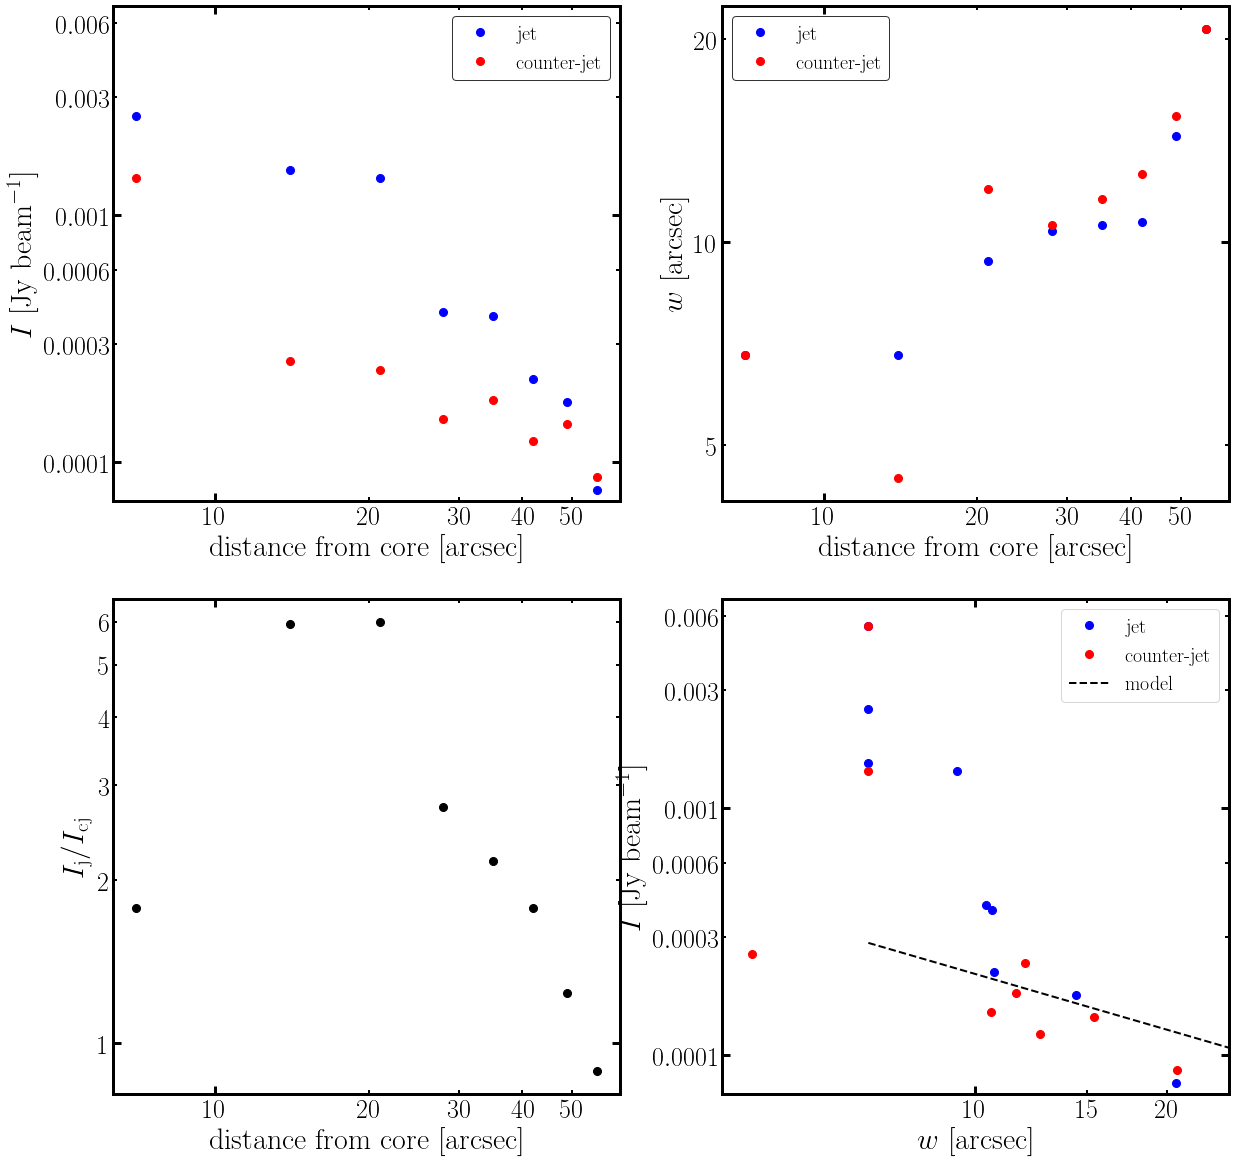

In [51]:

#inTable
table= ascii.read(outTables[0])
#table.remove_row(10)
b,c = splitter(table.columns[0])
tableCJ = table[0:len(b)+1]
tableCJrev = np.flip(tableCJ,0)

tableJ = table[len(b):]
tableJ.add_row(np.zeros(len(table.colnames))*np.nan)

widthCJ = tableCJrev['deconvolvedWidth']
widthJ = tableJ['deconvolvedWidth']

print np.nanmean(widthJ),np.nanmean(widthCJ)
widthRatio = np.divide(widthJ,widthCJ)

surfBrightCJ = tableCJrev['surfaceBrightness']
surfBrightJ = tableJ['surfaceBrightness']
print np.nanmean(surfBrightJ),np.nanmean(surfBrightCJ), np.nanmean(surfBrightJ)/np.nanmean(surfBrightCJ)

brightRatio = np.divide(surfBrightJ,surfBrightCJ)
cosAngle = np.divide(np.power(brightRatio,1./(2.+alpha)) - 1. , 1.+np.power(brightRatio,1./(2.+alpha)))/beta

angle = np.arccos(cosAngle)*180./np.pi

print 'Jets opening angle'
print angle

radius = [0,7,14,21,28,35,42,49,56,63,70]

outFig = figDir +'JetCJetAll1D.png'

bright = np.log10(table['surfaceBrightness'])
width = np.log10(table['deconvolvedWidth'])
m,b = np.polyfit(width, bright, 1) 

print 1./b
jCjPlot(radius,surfBrightJ,surfBrightCJ,widthJ,widthCJ,
        brightRatio,widthRatio,m,b,outFig)    



In [5]:
print radius

[0, 7, 14, 21, 28, 35, 42, 49, 56, 63, 70]
